In [1]:
import pandas as pd
import numpy as np
import cpi
from tqdm import tqdm, tqdm_notebook
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path_1 = '/Users/jenniferpaige/Desktop/TTS_10-Dec-2019_p1.csv'
file_path_2 = '/Users/jenniferpaige/Desktop/TTS_10-Dec-2019_p2.csv'
files = [file_path_1, file_path_2]
loaded_files = []
count = 0
for i in tqdm(range(1, len(files)+1)):
    exec(f"df{i} = pd.read_csv(files[{count}],encoding='iso-8859-1', parse_dates=['Installation Date'], usecols=['Installation Date','System Size','Total Installed Price','Customer Segment', 'State'],na_values=(-9999, '-9999'))")
    count+=1
[exec("loaded_files.append(df{})".format(i)) for i in range(1, len(files)+1)]
if len(loaded_files) > 1:
    df = pd.concat([i for i in loaded_files],ignore_index=True)
else: 
    df=loaded_files[0]
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.sort_values('installation_date', inplace=True)
df.set_index('installation_date', drop=True, inplace=True)
[df['total_installed_price'].replace(np.nan,round(df.loc[(df['total_installed_price'] != np.nan) & (df.index.year == i)]['total_installed_price'].median(),2),inplace=True) for i in tqdm(range(1998,2019))] 
df['date'] = df.index.date
df['adj_installed_price'] = round(df.apply(lambda x:cpi.inflate(x.total_installed_price, x.date), axis=1),2)
df['cost_per_watt'] = round(df['adj_installed_price']/ df['system_size']/1000,2)
null_list = []
for i in tqdm(range(len(df.cost_per_watt.resample('W').median()))):
    if df.cost_per_watt.resample('W').median()[i] >0:
        pass
    else:
        null_list.append(i)
y = df.cost_per_watt.resample('W').median()[null_list[-1]+1:]
if round(adfuller(y)[1],4) < 0.51:
    print("|       ADF P-value: {} \n|       Time Series achieved stationarity. \n|       Reject ADF H0".format(round(adfuller(y)[1],4)))
else:
    print('|       ADF P-value: {} \n|       Time Series is not stationary.   \n|       Fail to reject ADF H0'.format(round(adfuller(y)[1],4)))
weekly_differences = y.diff(periods=1).dropna()
if round(adfuller(weekly_differences)[1],4) < 0.51: 
    print('|       ADF P-value: {} \n|       Differenced data achieved stationarity. \n|       Reject ADF H0'.format(round(adfuller(weekly_differences)[1],4)))

100%|██████████| 1093/1093 [00:52<00:00, 20.77it/s]


|       ADF P-value: 0.9509 
|       Time Series is not stationary.   
|       Fail to reject ADF H0
|       ADF P-value: 0.0 
|       Differenced data achieved stationarity. 
|       Reject ADF H0


In [3]:
diff= pd.DataFrame(weekly_differences.copy())

In [4]:
df['year'] = df.index.year

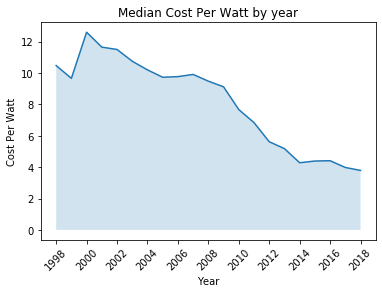

In [5]:
plt.plot(df.cost_per_watt.groupby(df['year']).median())
plt.fill_between(df.year.unique(), df.cost_per_watt.groupby(df['year']).median(), 0, alpha=.2)
plt.title('Median Cost Per Watt by year')
plt.xlabel('Year')
plt.ylabel('Cost Per Watt')
plt.xticks(ticks= list(df.year.unique())[::2], rotation=45)
plt.show()

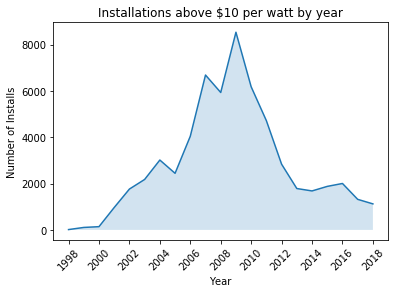

In [6]:
plt.plot(df.loc[df.cost_per_watt >10].groupby('year').count().system_size)
plt.fill_between(df.year.unique(), df.loc[df.cost_per_watt >10].groupby('year').count().system_size.values, 0, alpha=.2)
plt.title('Installations above $10 per watt by year')
plt.xlabel('Year')
plt.ylabel('Number of Installs')
plt.xticks(ticks= list(df.year.unique())[::2], rotation=45)
#plt.savefig("cost_per_watt_above_10.png")
plt.show()


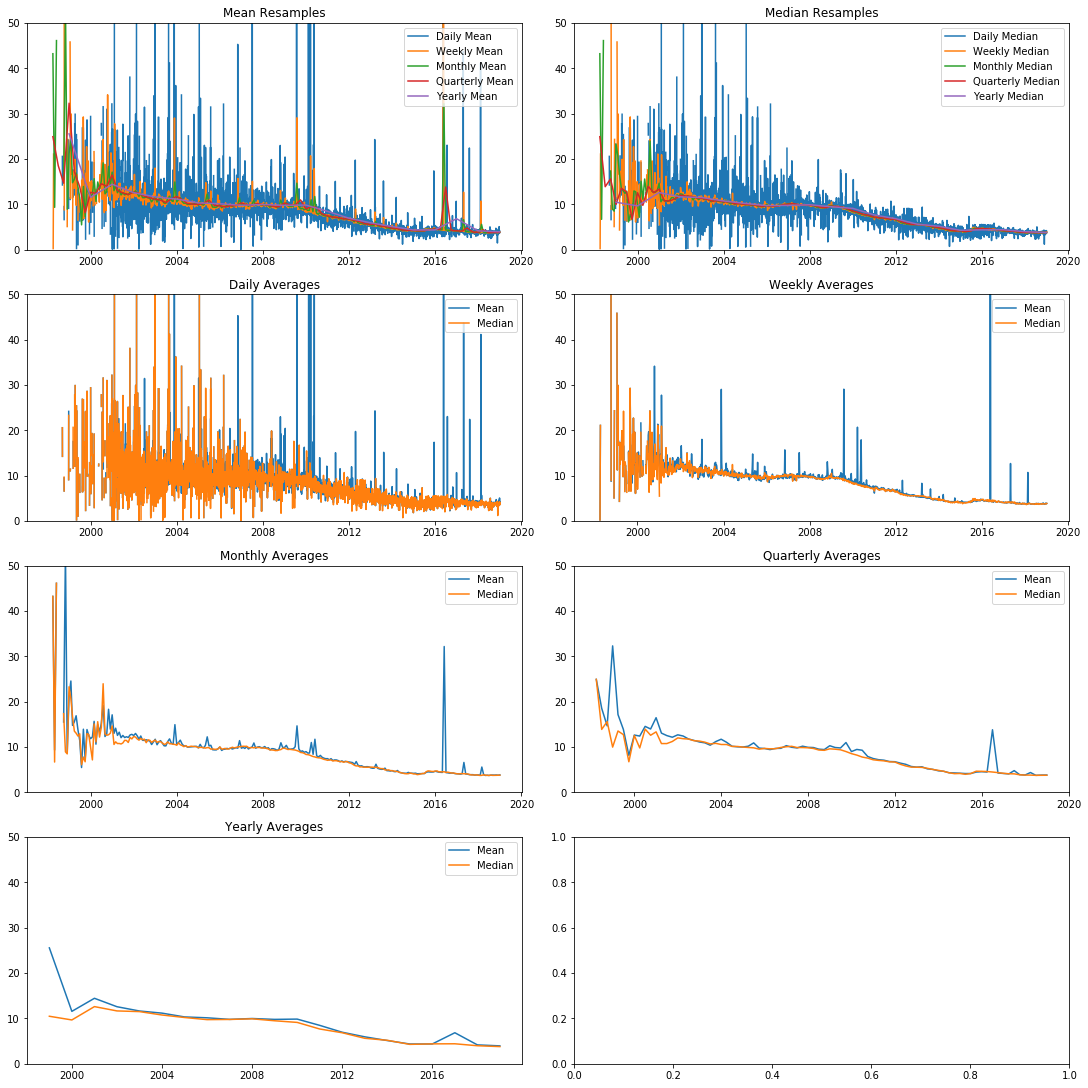

In [10]:
fig, ax = plt.subplots(4,2, figsize=(15,15), constrained_layout=True)
time_list, time_type = ['D', 'W', 'M', 'Q', 'Y'], ['Daily', 'Weekly', 'Monthly', 'Quarterly', 'Yearly']
time_dict = dict(zip(time_list, time_type))
resam_list = ['mean', 'median']
loc_list = [[0,0], [0,1],[1,0], [1,1], [2,0],[2,1], [3,0]]
time_cnt, count = 0,0

for t in time_list:
    for i in range(2):
        exec(f"ax{loc_list[i]}.plot(df.cost_per_watt.resample('{time_list[time_cnt]}').{resam_list[i]}(), label='{time_dict.get(time_list[time_cnt])} {resam_list[i]}'.title()) ")
        exec(f"ax{loc_list[i]}.set_title('{resam_list[i]} Resamples'.title())")
    time_cnt+=1

for i in range (2,7):
    for r in range(2):
        exec(f"ax{loc_list[i]}.plot(df.cost_per_watt.resample('{time_list[count]}').{resam_list[r]}(), label='{resam_list[r]}'.title())")
        exec(f"ax{loc_list[i]}.set_title('{time_dict.get(time_list[count])} averages'.title())")
    count+=1

for i in range(7):
    exec(f"ax{loc_list[i]}.legend(loc='upper right')")
    exec(f"ax{loc_list[i]}.set_ylim(0,50)")

#plt.savefig("mean_and_median_resamples.png")

In [40]:
sys_bins = [0.0, 2.5, 5.0, 7.5, 10, 12.5, 17.5, 42.5, 18000]

df['sys_size_group'] = pd.cut(df['system_size'], sys_bins)

pivot_tb = pd.pivot_table(df, values='cost_per_watt', index='year', columns='sys_size_group')

size_df = df.copy()
size_dummies = pd.get_dummies(size_df['sys_size_group'])
size_df = pd.concat([size_df, size_dummies], axis=1)
sizes_nums = []
for i in tqdm(range(len(size_df))):
    sizes_nums.append( str(size_df.sys_size_group[i]))
size_df['size_group'] = sizes_nums

df['date'] = df.index
df['num_of_days']  = df['date'] - df['date'][0]
df['num_of_days'] = df['num_of_days'].dt.days

per_watt = pd.DataFrame(df.cost_per_watt.sort_values())
per_watt = per_watt.sort_values(by='cost_per_watt', ascending=True)
watt_groups = per_watt.copy()
bins = [-.01, 2.15, 3, 3.75, 4.4, 5.15, 6, 8,722000]
watt_groups['size_group'] = pd.cut(watt_groups['cost_per_watt'], bins)

states = df[['state', 'cost_per_watt',]]
states.rename(columns={'cost_per_watt':'count'},inplace=True)
states = states.groupby('state').count()
states.sort_values('count')
states['state'] = states.index

df['count'] = 0
segs = ['RES', 'NON-RES', 'SCHOOL','COM', 'GOV', 'NON-PROFIT']

100%|██████████| 1543831/1543831 [01:40<00:00, 15307.92it/s]
/Users/jenniferpaige/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [21]:
pivot_tb

sys_size_group,"(0.0, 2.5]","(2.5, 5.0]","(5.0, 7.5]","(7.5, 10.0]","(10.0, 12.5]","(12.5, 17.5]","(17.5, 42.5]","(42.5, 18000.0]"
year,,,,,,,,
1998,40.672857,7.613333,5.110000,NaN,NaN,20.710000,NaN,0.250000
1999,15.584421,9.398133,9.535625,5.727143,7.428889,5.200000,7.290000,0.276667
2000,17.636126,11.069848,13.615333,7.275385,10.005000,NaN,NaN,3.840000
2001,14.918981,11.334150,10.573846,8.325429,9.645217,9.780000,7.338571,3.247500
2002,14.807557,11.333492,9.542649,8.062500,9.230818,7.893333,8.159000,2.846250
2003,13.414016,10.866144,9.950793,9.338964,16.123333,7.829211,8.148955,4.820000
2004,13.037209,10.093871,9.459725,9.022483,8.478035,8.179667,7.904122,6.906100
2005,14.487545,9.554695,8.874252,9.334893,8.601245,7.978939,7.754309,5.935468
2006,12.626069,9.760397,9.073150,9.069921,7.969413,8.542579,7.713866,6.704598


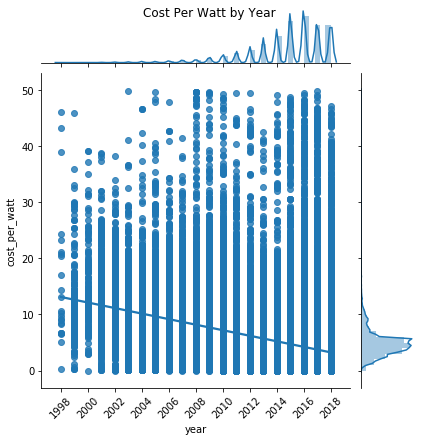

In [11]:
sns.jointplot(y='cost_per_watt' , x='year' , kind='reg', data=size_df.loc[size_df['cost_per_watt'] < 50])
plt.xticks(ticks= list(size_df.year.unique())[::2], rotation=45)
plt.suptitle('Cost Per Watt by Year')
#plt.savefig("cost_per_watt_by_year_scatter.png")
plt.show()

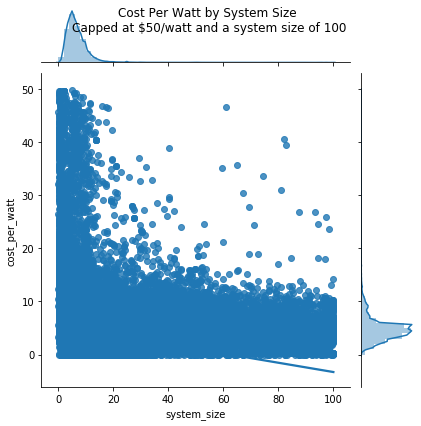

In [12]:
sns.jointplot(x='system_size' , y='cost_per_watt', kind='reg', 
              data=df.loc[(df['cost_per_watt'] < 50) & (df['system_size']<100)])
plt.suptitle('Cost Per Watt by System Size \nCapped at $50/watt and a system size of 100')
plt.show()

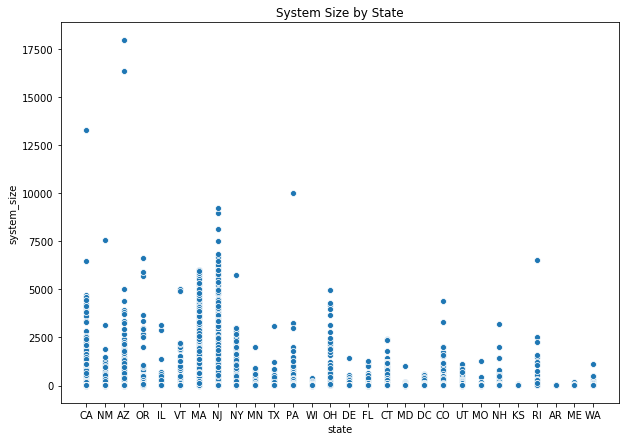

In [38]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='state', y='system_size', data=df)
plt.title('System Size by State')
plt.show()

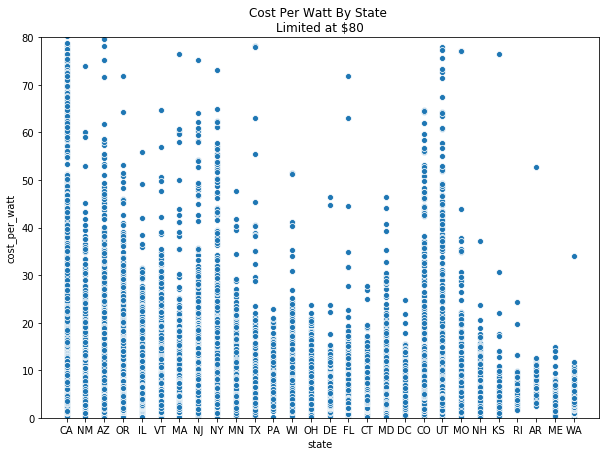

In [39]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='state', y='cost_per_watt', data=df)
plt.title('Cost Per Watt By State \nLimited at $80')
plt.ylim(0,80)
plt.show()

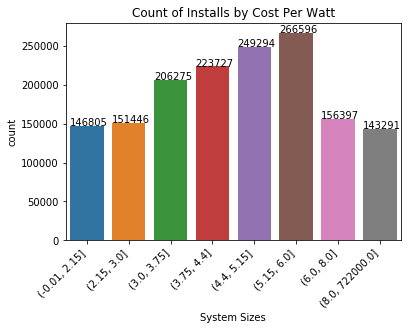

In [15]:
ax = sns.countplot(x='size_group', data=watt_groups)
plt.title('Count of Installs by Cost Per Watt')
plt.xlabel('System Sizes')
plt.xticks( rotation=45, horizontalalignment='right',fontweight='light')
for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x(), p.get_height()+200))
plt.show()

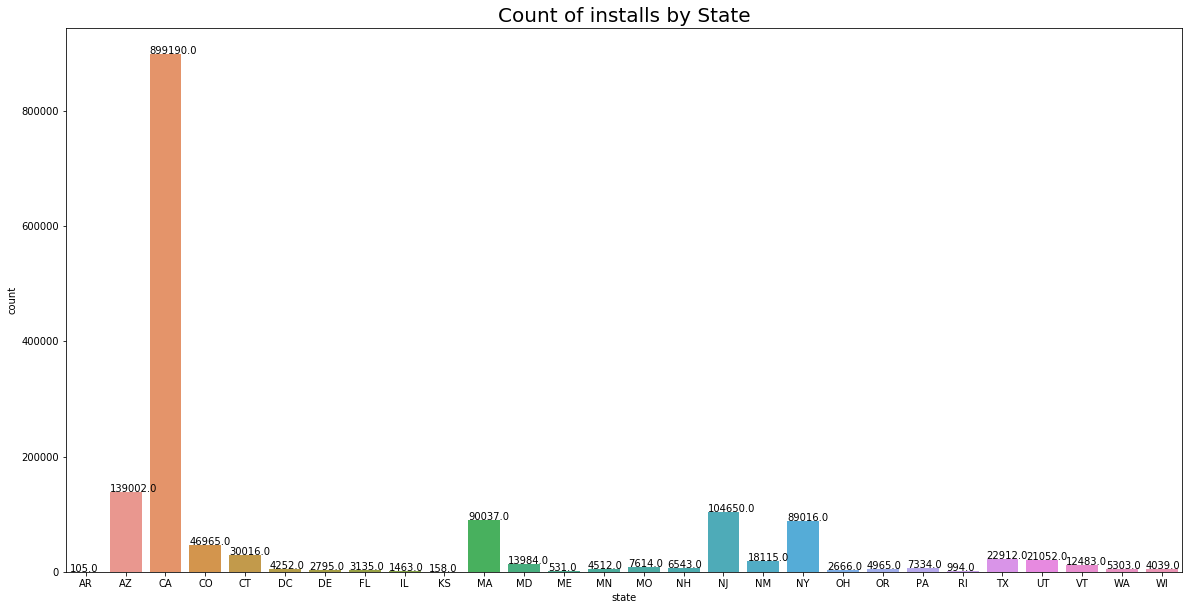

In [16]:
plt.figure(figsize=(20,10))
plt.tight_layout()
ax = sns.barplot(x='state', y='count', data=states)
for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x(), (p.get_height())))
plt.title('Count of installs by State', fontsize=20)
plt.show()

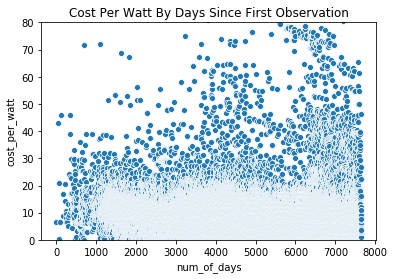

In [17]:
sns.scatterplot(x='num_of_days', y='cost_per_watt', data=df)
plt.title('Cost Per Watt By Days Since First Observation')
plt.axis(ymin=0, ymax=80)
plt.show()

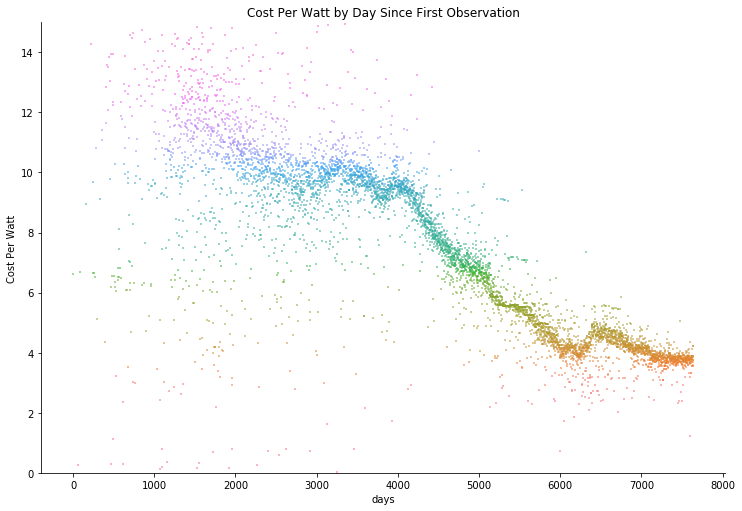

In [18]:
MedByDay = df.groupby(['num_of_days'])['cost_per_watt'].median()
MedByDay = MedByDay.reset_index()
g = sns.FacetGrid(MedByDay, hue='cost_per_watt', height=7, aspect=1.5)
g.map(plt.scatter, 'num_of_days', 'cost_per_watt', s=5, marker='+', alpha=0.5)
g.ax.set(xlabel='days',
         ylabel='Cost Per Watt', ylim=(0,15),
         title='Cost Per Watt by Day Since First Observation')
plt.show()

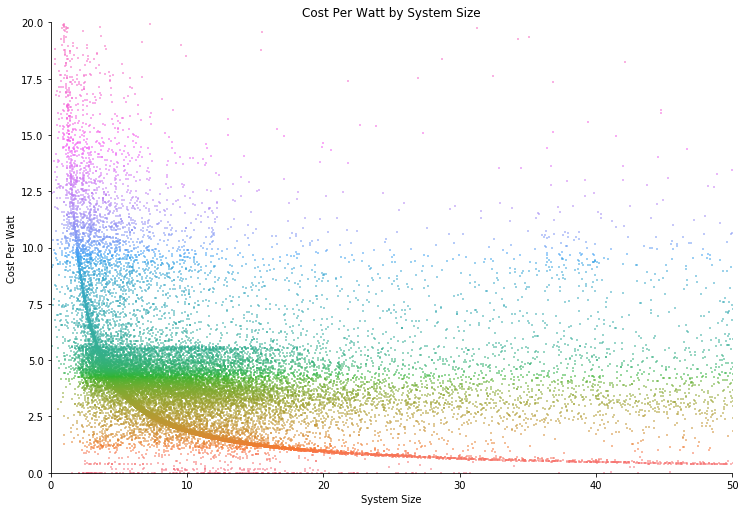

In [19]:
MedByDay = df.groupby(['system_size'])['cost_per_watt'].median()
MedByDay = MedByDay.reset_index()
g = sns.FacetGrid(MedByDay, hue='cost_per_watt', height=7, aspect=1.5)
g.map(plt.scatter, 'system_size', 'cost_per_watt', s=5, marker='+', alpha=0.5)
g.ax.set(xlabel='System Size',
         ylabel='Cost Per Watt', ylim=(0,20), xlim=(0,50),
         title='Cost Per Watt by System Size')
plt.show()

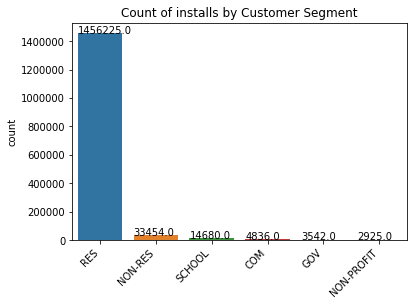

In [20]:
ax = sns.barplot(x=segs, y='count', data=df.groupby('customer_segment')['count', 'customer_segment'].count().sort_values('count', ascending=False))

for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x(), (p.get_height())))
plt.xticks( rotation=45, horizontalalignment='right',fontweight='light')
plt.title('Count of installs by Customer Segment')
plt.show()